In [6]:
import sys
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage.interpolation as ndii
import pprint
import time

# global constants
RE_IDX = 0
IM_IDX = 1
ROWS_AXIS = 0
COLS_AXIS = 1
polarMode = "spline"
noiseMode = "none" # "gaussian", "s&p", "none"
noiseIntensity = {'sigma' : 2, 'mean' : 0, 'whiteThreshold' : 0.01, 'blackThreshold' : 0.99}
resultsComparation = False

# this function will calculates parameters for log polar transformation
# (center of transformation, angle step and log base)
def computeLogPolarParameters(img):
	# Step 1 - Get center of the transformation
    centerTrans = [math.floor((img.shape[ROWS_AXIS] + 1) / 2), math.floor((img.shape[COLS_AXIS] + 1 ) / 2)]
	# Step 2 - Estimate dimensions of final image after discrete log-polar transformation
	# num of columns = log(radius)
	# num of rows = angle in radius (0, 2pi)
    maxDiff = np.maximum(centerTrans, np.asarray(img.shape) - centerTrans)
    maxDistance = ((maxDiff[0] ** 2 + maxDiff[1] ** 2 ) ** 0.5)
    dimsLogPolar = [0,0]
    dimsLogPolar[COLS_AXIS] = img.shape[COLS_AXIS]
    dimsLogPolar[ROWS_AXIS] = img.shape[ROWS_AXIS]
    # Step 2.1 - Estimate log base
    logBase = math.exp(math.log(maxDistance) / dimsLogPolar[COLS_AXIS])
    # Step 3 - Calculate step for angle in log polar coordinates
    angleStep = ( 1.0 * math.pi ) / dimsLogPolar[ROWS_AXIS]
    return (centerTrans, angleStep, logBase)

# converts image to its log polar representation
# returns the log polar representation and log base
def convertToLogPolar(img, centerTrans, angleStep, logBase, mode = "nearest"):
    if mode == "nearest":
        # Step 1 - Initialize transformed image
        transformedImage = np.zeros(img.shape, dtype = img.dtype)
        # Step 2 - Apply reverse log polar transformation
        for radius in range(img.shape[COLS_AXIS]): # start with radius, because calculating exponential power is time consuming
            actRadius = logBase ** radius
            for angle in range(img.shape[ROWS_AXIS]):
                anglePi =  angle * angleStep
                # calculate euclidian coordinates (source: https://en.wikipedia.org/wiki/Log-polar_coordinates)
                row = int(centerTrans[ROWS_AXIS] + actRadius * math.sin(anglePi))
                col = int(centerTrans[COLS_AXIS] + actRadius * math.cos(anglePi))
                # copy pixel from the location to log polar image
                if 0 <= row < img.shape[ROWS_AXIS] and 0 <= col < img.shape[COLS_AXIS]:
                    transformedImage[angle, radius] = img[row, col]

        return transformedImage
    else:
        print("Base: " + str(logBase))
        # create matrix with angles
        anglesMap = np.zeros(img.shape, dtype=np.float64)
        # each column has 0 in its first row and -pi in its last row
        anglesVector = -np.linspace(0, np.pi, img.shape[0], endpoint=False)
        # initialize it by columns using the same vector
        anglesMap.T[:] = anglesVector
        # create matrix with radii
        radiusMap = np.zeros(img.shape, dtype=np.float64)
        # each line contains a vector with numbers from  in (0, cols) to power logBase
        radiusVector = np.power(logBase, np.arange(img.shape[1], dtype=np.float64)) - 1.0
        # initialize it by rows using the same vector
        radiusMap[:] = radiusVector
        # calculate x coordinates (source: https://en.wikipedia.org/wiki/Log-polar_coordinates)
        x = radiusMap * np.sin(anglesMap) + centerTrans[1]
        # calculate y coordinates (source: https://en.wikipedia.org/wiki/Log-polar_coordinates)
        y = radiusMap * np.cos(anglesMap) + centerTrans[0]
        # initialize final image
        outputImg = np.zeros(img.shape)
        # use spline interpolation to map pixels from original image to calculated coordinates
        ndii.map_coordinates(img, [x, y], output=outputImg)
        return outputImg


# computes phase correlation and returns position of pixel with highest value (row, column)
def phaseCorrelation(img_orig, img_transformed):
    # Step 3.1 - Initialize complex conjugates for original image and magnitudes
    orig_conj = np.copy(img_orig)
    orig_conj[:,:,IM_IDX] = -orig_conj[:,:,IM_IDX]
    orig_mags = cv2.magnitude(img_orig[:,:,RE_IDX],img_orig[:,:,IM_IDX])
    img_trans_mags = cv2.magnitude(img_transformed[:,:,RE_IDX],img_transformed[:,:,IM_IDX])
    # Step 3.2 - Do deconvolution
    # multiplication compex numbers ===> (x + yi) * (u + vi) = (xu - yv) + (xv + yu)i
    # deconvolution ( H* x G ) / |H x G|
    realPart = (orig_conj[:,:,RE_IDX] * img_transformed[:,:,RE_IDX] - orig_conj[:,:,IM_IDX] * img_transformed[:,:,IM_IDX]) / (orig_mags * img_trans_mags)
    imaginaryPart = (orig_conj[:,:,RE_IDX] * img_transformed[:,:,IM_IDX] + orig_conj[:,:,IM_IDX] * img_transformed[:,:,RE_IDX]) / ( orig_mags * img_trans_mags)
    result = np.dstack((realPart, imaginaryPart))
    result_idft = cv2.idft(result)
    # Step 3.3 - Find Max value (angle and scaling factor)
    result_mags = cv2.magnitude(result_idft[:,:,RE_IDX],result_idft[:,:,IM_IDX])
    return np.unravel_index( np.argmax(result_mags), result_mags.shape)


# adds artifical noise to images
def addNoiseToImage(img, noise, noiseIntensity):
    if noise == 's&p':
        print("Adding S&P Noise: wT = " + str(noiseIntensity['whiteThreshold']) + "; bT = " + str(noiseIntensity['blackThreshold']))
        # generate probabilities from uniform distribution
        distData = np.random.uniform(0.0, 1.0, img.shape).reshape(img.shape)
        # set ones below whiteThreshold to white
        img[distData < noiseIntensity['whiteThreshold']] = 255
        # set ones above blackThreshold to black
        img[distData > noiseIntensity['blackThreshold']] = 0
        return img
    else:
        if noise == 'gaussian':
            print("Adding Gaussian noise: sigma = " + str(noiseIntensity['sigma']) + '; mean = ' + str(noiseIntensity['mean']))
            return noiseIntensity['sigma'] * np.random.randn(img.shape[0], img.shape[1]) + img + noiseIntensity['mean']
        else:
            return img

# reads image, runs FFT and returns FFT image + its magnitude spectrum
def readImage(img):
    imgData = cv2.imread(img,0) # 0 means Grayscale
    imgData = cv2.resize(imgData, (64, 64), interpolation = cv2.INTER_AREA)
    imgData = addNoiseToImage(imgData, noiseMode, noiseIntensity)
    imgFft, imgFftShifted = calculateFft(imgData) # FFT of the image
    imgMags = cv2.magnitude(imgFftShifted[:,:,RE_IDX],imgFftShifted[:,:,IM_IDX])
    return (imgData, imgFftShifted, imgMags)


# applies highpass filter and returns the image
# H(col, row) = (1.0 - X(col, row)) * (2.0 - X(col, row)), row and col have to be transformed to range <-pi/2, pi/2>
# X(valX, valY) = cos(pi * valX) * cos(pi * valY), both valX and valY in range <-pi/2, pi/2>
def prepareHighPassFilter(img):
    pi2 = math.pi / 2.0
    # transform number of rows to <-pi/2,pi/2> range and calculate cos for each element
    rows = np.cos(np.linspace(-pi2, pi2, img.shape[0]))
    # transform number of cols to <-pi/2,pi/2> range and calculate cos for each element
    cols = np.cos(np.linspace(-pi2, pi2, img.shape[1]))
    # creates matrix the whole image
    x = np.outer( rows, cols)
    return (1.0 - x) * (2.0 - x)


# Central point for running FFT
def calculateFft(img):
    imgTmp  = np.float32(img)
    # FFT of the image
    imgFft = cv2.dft(imgTmp,flags = cv2.DFT_COMPLEX_OUTPUT)
    # the FFT shift is needed in order to center the results
    imgFftShifted = np.fft.fftshift(imgFft)
    return (imgFft, imgFftShifted)

# main script
def main(image_path_1, image_path_2):
    timeStart = time.time()
    # Step 1 - Apply FFT on both images and get their magnitude spectrums
    # image (we are looking for), lets call it original
    imgOriginal, imgOriginalFft, imgOriginalMags = readImage(image_path_1)
    # image (we are searching in), lets call it transformed
    imgTransformed, imgTransformedFft, imgTransformedMags = readImage(image_path_2)

    # Step 2 - Apply highpass filter on their magnitude spectrums
    highPassFilter = prepareHighPassFilter(imgOriginalMags)
    imgOriginalMagsFilter = imgOriginalMags * highPassFilter
    imgTransformedMagsFilter = imgTransformedMags * highPassFilter

    # Step 3 - Convert magnitudes both images to log-polar coordinates
    # Step 3.1 - Precompute parameters (both images have the same dimensions)
    centerTrans, angleStep, logBase = computeLogPolarParameters(imgOriginalMagsFilter)
    imgOriginalLogPolar = convertToLogPolar(imgOriginalMagsFilter, centerTrans, angleStep, logBase, polarMode)
    imgTransformedLogPolar = convertToLogPolar(imgTransformedMagsFilter, centerTrans, angleStep, logBase, polarMode)

    # Step 3.1 - Apply FFT on magnitude spectrums in log polar coordinates (in this case, not using FFT shift as it leads to computing [180-angle] results)
    imgOriginalLogPolarComplex = cv2.dft(np.float32(imgOriginalLogPolar),flags = cv2.DFT_COMPLEX_OUTPUT)
    imgTransformedLogPolarComplex = cv2.dft(np.float32(imgTransformedLogPolar),flags = cv2.DFT_COMPLEX_OUTPUT)

    # Step 4 - Apply phase corelation on both images (FFT applied on log polar images) to retrieve rotation (angle) and scale factor
    angle, scale = phaseCorrelation(imgOriginalLogPolarComplex, imgTransformedLogPolarComplex)
    # Step 4.1 Convert to degrees based on formula in paper (26) and adjust it to (-pi/2, pi/2) range
    angleDeg = -(float(angle) * 180.0 ) / imgOriginalLogPolarComplex.shape[0]
    if angleDeg < - 45:
        angleDeg += 180
    else:
        if angleDeg > 90.0:
            angleDeg -= 180

    # Step 4.2 Calculate scale factor based on formula in paper (25)
    scaleFactor = logBase ** scale

    # Step 5 - Apply rotation and scaling on transformed image
    transformMatrix = cv2.getRotationMatrix2D((centerTrans[0], centerTrans[1]), angleDeg, scaleFactor)
    imgTransformedNew = cv2.warpAffine(imgTransformed, transformMatrix, (imgTransformed.shape[1], imgTransformed.shape[0]) )

    # Step 6 - Apply phase corelation on both images to retrieve translation
    # Step 6.1 Apply FFT to newly created transformed image
    imgTransformedNewFft, imgTransformedNewftShifted = calculateFft(imgTransformedNew)
    # Step 6.2 - Use phase corelation to get translation coordinates
    y, x = phaseCorrelation(imgTransformedNewftShifted, imgOriginalFft)
    # Step 6.3 Apply translation on the final image
    if x > imgOriginal.shape[0] // 2:
        x -= imgOriginal.shape[0]
    if y > imgOriginal.shape[1] // 2:
        y -= imgOriginal.shape[1]

    translationMatrix = np.float32([[1,0,-x],[0,1,-y]])
    imgFinal = cv2.warpAffine(imgTransformedNew, translationMatrix, (imgTransformed.shape[1], imgTransformed.shape[0]))
    timeEnd = time.time()

    # Step 7 - Return final results (rotation, scale factor, translation)
    print("Angle = " + str(angleDeg) + " Deg")
    print("Scale = " + str(scaleFactor))
    print("Translation")
    print("X = " + str(-x))
    print("Y = " + str(-y))
    print("Time = " + str(timeEnd - timeStart))

    if resultsComparation:
        plt.subplot(221),plt.imshow(imgOriginal, cmap = 'gray')
        plt.subplot(222),plt.imshow(imgTransformed, cmap = 'gray')
        plt.subplot(223),plt.imshow(imgOriginal - imgFinal, cmap = 'bwr')
        plt.subplot(224),plt.imshow(imgFinal, cmap = 'gray')
        plt.show()
    else:
        plt.subplot(521),plt.imshow(imgOriginal, cmap = 'gray')
        plt.subplot(522),plt.imshow(imgTransformed, cmap = 'gray')
        plt.subplot(523),plt.imshow(imgOriginalMagsFilter, cmap = 'gray')
        plt.subplot(524),plt.imshow(imgTransformedMagsFilter, cmap = 'gray')
        plt.subplot(525),plt.imshow(imgOriginalLogPolar, cmap = 'gray')
        plt.subplot(526),plt.imshow(imgTransformedLogPolar, cmap = 'gray')
        plt.subplot(527),plt.imshow(imgTransformedNew, cmap = 'gray')
        plt.subplot(528),plt.imshow(imgOriginal - imgFinal, cmap = 'bwr')
        plt.subplot(529),plt.imshow(imgFinal, cmap = 'gray')
        plt.show()

In [59]:
img1 = "/home/yyelisieiev/luftr_data/RivetClass2/train/99_rivet.png"
img2 = "/home/yyelisieiev/luftr_data/RivetClass2/train/11_rivet.png"

Base: 1.061377227289262
Base: 1.061377227289262
Angle = -2.8125 Deg
Scale = 1.0
Translation
X = 0
Y = 0
Time = 0.007544994354248047


<ipython-input-6-d7b20495c230>:93: RuntimeWarning: invalid value encountered in true_divide
  realPart = (orig_conj[:,:,RE_IDX] * img_transformed[:,:,RE_IDX] - orig_conj[:,:,IM_IDX] * img_transformed[:,:,IM_IDX]) / (orig_mags * img_trans_mags)
<ipython-input-6-d7b20495c230>:94: RuntimeWarning: invalid value encountered in true_divide
  imaginaryPart = (orig_conj[:,:,RE_IDX] * img_transformed[:,:,IM_IDX] + orig_conj[:,:,IM_IDX] * img_transformed[:,:,RE_IDX]) / ( orig_mags * img_trans_mags)


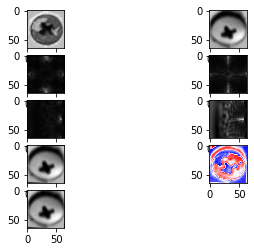

In [60]:
main(img1, img2)